# Deep Learning & Art - Neural Style Transfer

In [83]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf
import pprint
%matplotlib inline

## 1. Problem Statement

**Neural Style Transfer (NST)** can merge a **content** image (C) and a **style** image (S) to create a **generated** image (G). Generate an image of the Louvre museum in Paris (C) mixed with a painting by Claude Monet (S) through NST.

## 2. Transfer Learning

NST builds on a pre-trained convolutional network. We use a VGG-19 that has already been trained on the ImageNet database.

In [84]:
pp = pprint.PrettyPrinter(indent=4)
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
pp.pprint(model)

{   'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>,
    'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>,
    'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>,
    'avgpool4': <tf.Tensor 'AvgPool_3:0' shape=(1, 19, 25, 512) dtype=float32>,
    'avgpool5': <tf.Tensor 'AvgPool_4:0' shape=(1, 10, 13, 512) dtype=float32>,
    'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>,
    'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>,
    'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>,
    'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>,
    'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) 

## 3. Neural Style Transfer (NST)

1. Build the content cost function $J_{content}(C,G)$
2. Build the style cost function $J_{style}(S,G)$
3. Put it together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$. 

### 3.1 - Computing Content Cost

(300, 400, 3)


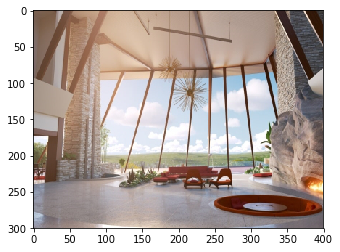

In [85]:
# load C
content_image = scipy.misc.imread("images/incredibles-house.jpg")
imshow(content_image);
print(content_image.shape)

Choose a "middle" activation layer $a^{[l]}$ to represent the content of an image, preferrably a layer in the middle of the network. Then forward propagate C and G through the VGG network, letting $a^{(C)}$ and $a^{(G)}$ be their corresponding hidden layer activation, each of shape $n_H \times n_W \times n_C$. Compute the content cost function $J_{content}(C,G)$:

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

$n_H, n_W$ and $n_C$ are the height, width and number of channels of the hidden layer chosen, and appear in a normalization term in the cost. 

**`compute_content_cost() Overview`**

```
Arguments:
a_C = hidden layer activations representing content of the image C (1, n_H, n_W, n_C)  
a_G = hidden layer activations representing content of the image G (1, n_H, n_W, n_C)

Returns: 
J_content = computed content cost
```

In [86]:
def compute_content_cost(a_C, a_G):

    m, n_H, n_W, n_C = a_G.get_shape().as_list()               # retrieve dimensions from a_G
    a_C_unrolled = tf.reshape(a_C,shape=(n_H * n_W, n_C))      # reshape a_C and a_G
    a_G_unrolled = tf.reshape(a_G,shape=(n_H * n_W, n_C))
    
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled,a_G_unrolled)))/(4 * n_H * n_W * n_C)   # compute the cost
    
    return J_content

### 3.2 - Computing Style Cost

(300, 400, 3)


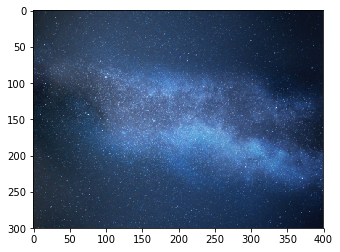

In [87]:
# load style image
style_image = scipy.misc.imread("images/stars.jpg")
imshow(style_image);
print(style_image.shape)

### 3.2.1 - Style Matrix

The **style matrix**, or Gram matrix, of a set of vectors $(v_{1},\dots ,v_{n})$ is the matrix of dot products, whose entries are ${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$. $G_{ij}$ compares how similar $v_i$ is to $v_j$: if they are highly similar, they will have a large dot product, and thus for $G_{ij}$ to be large.

#### Compute $G_{gram}$

$$\mathbf{G}_{gram} = \mathbf{A}_{unrolled} \mathbf{A}_{unrolled}^T$$

$G_{(gram)i,j}$ is a $(n_C,n_C)$ matrix where $n_C$ is the number of filters/channels. 

The diagonal elements $G_{(gram)ii}$ measure how "active" a filter $i$ is. If filter $i$ is detecting vertical textures in an image, and $G_{(gram)ii}$ is large, then the image has a lot of vertical texture. By capturing the prevalence of different types of features ($G_{(gram)ii}$), as well as how much different features occur together ($G_{(gram)ij}$), the Style matrix $G_{gram}$ measures the style of an image. 

**`gram_matrix() Overview`**: 
```
Argument:
A = (n_C, n_H*n_W)

Returns:
GA = Gram matrix of A, of shape (n_C, n_C)
```

In [88]:
def gram_matrix(A):
    
    GA = tf.matmul(A, tf.transpose(A))
    
    return GA

### 3.2.2 - Style Cost

Minimize the distance between the Gram matrix of S and the gram matrix of G, where the style cost for this layer is defined as: 

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2\tag{2} $$

**`compute_layer_style_cost() Overview`**:

`Compute the style cost for a single layer.`

```
Arguments:
a_S = hidden layer activations representing style S (1, n_H, n_W, n_C) 
a_G = hidden layer activations representing style G (1, n_H, n_W, n_C)

Returns: 
J_style_layer = tensor representing a scalar value
```

In [89]:
def compute_layer_style_cost(a_S, a_G):
    
    # retrieve a_G dimensions 
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # reshape images as (n_C, n_H*n_W)
    a_S = tf.reshape(a_S, shape=(n_H * n_W, n_C))
    a_G = tf.reshape(a_G, shape=(n_H * n_W, n_C))

    # computing gram_matrices for S and G
    GS = gram_matrix(tf.transpose(a_S))
    GG = gram_matrix(tf.transpose(a_G))

    # compute the loss
    J_style_layer = tf.reduce_sum(tf.square(tf.subtract(GS,GG))) / (4*(n_C*n_C)*(n_W * n_H) * (n_W * n_H)) 
        
    return J_style_layer

### 3.2.3 Style Weights

After capturing the style from one layer, we can merge style costs from several different layers. Each layer will be given weights ($\lambda^{[l]}$) that reflect how much each layer will contribute to the style.

To combine the style costs for the different layers, use:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where $\lambda^{[l]}$ is given in `STYLE_LAYERS`. 


In [90]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

### Compute Style Cost Over Multiple Layers

**`compute_style_cost() Overview`**:
```
Computes the overall style cost from several chosen layers

Arguments:
model = tensorflow model
STYLE_LAYERS = A list containing the names of the layers we want to extract style from and their coefficients

Returns: 
J_style = tensor representing a scalar value, style cost defined above by equation (2)
```

In [91]:
def compute_style_cost(model, STYLE_LAYERS):
    
    J_style = 0                                                 # initialize the overall style cost

    for layer_name, coeff in STYLE_LAYERS:
        out = model[layer_name]                                 # select output tensor of current layer
        a_S = sess.run(out)                                     # set a_S to be the hidden layer activation from selected layer
        a_G = out                                               # set a_G to be hidden layer activation from same layer
        
        J_style_layer = compute_layer_style_cost(a_S, a_G)      # compute style_cost for current layer
        J_style += coeff * J_style_layer                        # add coeff * J_style_layer of current layer to style cost

    return J_style

### 3.3 - Define the Total Cost to Optimize

The cost function that minimizes both the style and the content cost is 
$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

**`total_cost() Overview`**:

```
Computes the total cost function
    
Arguments:
J_content -- content cost coded above
J_style -- style cost coded above
alpha -- hyperparameter weighting the importance of the content cost
beta -- hyperparameter weighting the importance of the style cost

Returns:
J -- total cost as defined by the formula above.
```

In [92]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):

    J = alpha * J_content + beta * J_style
    
    return J

## 4. Solving the optimization problem

#### Interactive Sessions

The "Interactive Session" installs itself as the default session to build a graph, allowing you to run variables without constantly needing to refer to the session object (calling "sess.run()").  

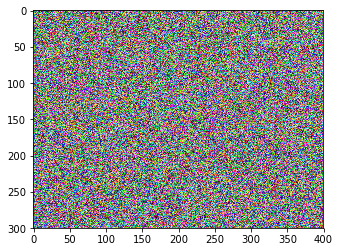

In [93]:
# START THE INTERACTIVE SESSION
tf.reset_default_graph()              # reset the graph
sess = tf.InteractiveSession()        # start interactive session  

# LOAD, RESHAPE, NORMALIZE CONTENT IMAGE
content_image = scipy.misc.imread("images/incredibles-house.jpg")
content_image = reshape_and_normalize_image(content_image)

# LOAD, RESHAPE, NORMALIZE STYLE IMAGE
style_image = scipy.misc.imread("images/stars.jpg")
style_image = reshape_and_normalize_image(style_image)

# RANDOMLY INITIALIZE GENERATED IMAGE
generated_image = generate_noise_image(content_image)
imshow(generated_image[0]);

# LOAD VGG19 MODEL
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

In [95]:
# CONTENT COST
sess.run(model['input'].assign(content_image))          # assign the content image as input of VGG model
out = model['conv4_2']                                  # select output tensor of layer conv4_2
a_C = sess.run(out)                                     # set a_C to be the hidden layer activation from selected layer
a_G = out                                               # set a_G to be the hidden layer activation from selected layer
J_content = compute_content_cost(a_C, a_G)              # compute content cost

# STYLE COST
sess.run(model['input'].assign(style_image))            # assign the style image as input of VGG model
J_style = compute_style_cost(model, STYLE_LAYERS)       # compute style cost

# TOTAL COST
J = total_cost(J_content, J_style, 10, 40)

# OPTIMIZER
optimizer = tf.train.AdamOptimizer(2.0)                 # define optimizer
train_step = optimizer.minimize(J)                      # define train_step

In [96]:
def model_nn(sess, input_image, num_iterations = 200):
    
    sess.run(tf.global_variables_initializer())                              # initialize global variables
    generated_image=sess.run(model['input'].assign(input_image))             # run noisy input image through model
    
    for i in range(num_iterations):
    
        sess.run(train_step)                                                 # run session to minimize total cost
        generated_image = sess.run(model['input'])                           # compute generated image 

        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            save_image("output/" + str(i) + ".png", generated_image)        # save current G in "/output" directory
    
    save_image('output/generated_image.jpg', generated_image)               # save last generated image
    
    return generated_image

In [97]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 7.23928e+09
content cost = 9052.2
style cost = 1.8098e+08
Iteration 20 :
total cost = 2.56866e+09
content cost = 16051.4
style cost = 6.42124e+07
Iteration 40 :
total cost = 1.44149e+09
content cost = 19128.7
style cost = 3.60324e+07
Iteration 60 :
total cost = 9.32797e+08
content cost = 20650.1
style cost = 2.33148e+07
Iteration 80 :
total cost = 6.41677e+08
content cost = 21491.5
style cost = 1.60366e+07
Iteration 100 :
total cost = 4.53018e+08
content cost = 22100.9
style cost = 1.13199e+07
Iteration 120 :
total cost = 3.24978e+08
content cost = 22526.3
style cost = 8.11883e+06
Iteration 140 :
total cost = 2.37901e+08
content cost = 22851.3
style cost = 5.94181e+06
Iteration 160 :
total cost = 1.78607e+08
content cost = 23101.5
style cost = 4.45941e+06
Iteration 180 :
total cost = 1.37359e+08
content cost = 23311.9
style cost = 3.42815e+06


array([[[[  59.74954605,   11.25314713,  193.87747192],
         [ -89.91118622,  -58.91314697,   20.91370392],
         [ -42.49859238,  -51.07521057,   59.34821701],
         ..., 
         [ -86.85218811,  -83.77910614,  105.99279022],
         [ -50.35242081, -146.09545898,   94.3660202 ],
         [  16.07615852,  -61.93438721,  118.71001434]],

        [[ -95.05171967,  -92.77790833,   25.82286644],
         [-171.16375732,  -91.31932831,  -33.03960419],
         [ -86.02863312,  -36.48504257,   40.72214508],
         ..., 
         [-126.69136047,  -87.75972748,   30.33823013],
         [-238.54595947, -133.16769409,  -18.43511391],
         [ -67.74891663, -170.1025238 ,   47.76101685]],

        [[   3.94526649,  -36.20094299,   65.55809784],
         [ -57.03516769,  -81.30415344,   57.19816971],
         [ -89.82811737,  -37.56363297,    6.93420506],
         ..., 
         [-131.20753479,  -75.73806763,   68.33958435],
         [-194.08885193, -110.36496735,  127.07167816],

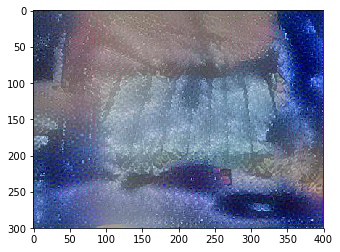

In [98]:
style_image = scipy.misc.imread("output/generated_image.jpg")
imshow(style_image);